# Spatial Analysis of Tumor Cell Clustering Using Ripley's L-Function



Description:
This notebook analyzes the spatial distribution of tumor cells in a spatial transcriptomics dataset 
using Ripley's L-function. The function `Ripley(adata)` evaluates whether tumor cells are randomly 
distributed, clustered, or dispersed by comparing observed spatial patterns to a simulated null model.

Methodology:
- Extracts tumor cells from `adata` based on the 'first_type' label.
- Computes Ripley's L-statistic up to a maximum distance of 500 units.
- Generates 100 random simulations to estimate confidence intervals.
- Plots the tumor L-statistic against a 95% confidence envelope.

Interpretation:
- If the tumor L-statistic lies above the confidence envelope → Tumor cells exhibit significant clustering.
- If it lies below the envelope → Tumor cells are more dispersed than expected.
- If it stays within the envelope → The spatial distribution follows random expectations.


Author: Neriman Tokcan
Date: 2025



In [1]:
import tensorly as tl
from glob import glob
import os
import math
import scanpy as sc
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm
import anndata
import timeit
from matplotlib import cm
import torch
from scipy import stats
import matplotlib.colors as mcolors
from tensorly.decomposition import tucker
from IPython.display import display
import seaborn as sns
#import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import datetime
now = datetime.datetime.now()
import scipy.optimize
import scipy.stats
import csv
from scipy.sparse import csr_matrix
%pylab inline
from scipy.spatial import distance
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatch

import gzip, pickle
from scipy.spatial.distance import cdist
import pickle, pprint
from scipy import io
from six.moves import cPickle
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
#from scipy.sparse import csr_matrix
from scipy import sparse

import gzip
import shutil

from sklearn.neighbors import NearestNeighbors

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
os.chdir("/home/ntokcan/Github_2025/Data")

In [6]:
import squidpy as sq
##https://squidpy.readthedocs.io/en/stable/
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [51]:
import shutil

shutil.copy("/home/ntokcan/pucks_2024/pucks_enrichment/SS_1.h5ad", "/home/ntokcan/Github_2025/Data")


'/home/ntokcan/Github_2025/Data/SS_1.h5ad'

In [35]:
adata=sc.read('/home/ntokcan/Github_2025/Data/SS_25.h5ad')

In [36]:
adata

AnnData object with n_obs × n_vars = 42762 × 4086
    obs: 'x', 'y', 'spot_class', 'first_type', 'second_type', 'first_class', 'second_class', 'min_score', 'singlet_score', 'conv_all', 'conv_doublet'
    uns: 'first_type_colors'
    obsm: 'spatial'

In [37]:
adata.obs

,x,y,spot_class,first_type,second_type,first_class,second_class,min_score,singlet_score,conv_all,conv_doublet
CGTTTTTTTTTTTT-1,1284.3,1787.6,doublet_certain,Macrophages,CD4_T_cells,False,False,3095.966561,3720.638722,True,True
ATCCCTCCTAATTT-1,583.4,2155.8,doublet_certain,CD4_T_cells,Macrophages,False,False,2223.595080,2800.957991,True,True
TACTACCCTATTCA-1,1826.3,4565.4,doublet_certain,Macrophages,CD4_T_cells,False,False,1858.024517,2249.651037,True,True
TATGTCTAATGTAA-1,4115.7,3264.0,doublet_certain,Macrophages,CD4_T_cells,False,False,2096.127714,2531.781124,True,True
CACTNCTGGATCTT-1,2860.5,894.5,doublet_certain,Macrophages,CD4_T_cells,False,False,1837.604453,2328.253798,True,True
...,...,...,...,...,...,...,...,...,...,...,...
AAATGCCGCTTCTC-1,1732.5,3830.0,singlet,Macrophages,Monocytes,False,False,125.354955,125.356446,True,True
TAAGGAAAGCAGCG-1,3065.1,2414.2,singlet,Macrophages,Fibroblasts,False,False,113.874144,116.934315,True,True
GTCGCGATTCGTGC-1,2869.0,2422.0,singlet,Macrophages,B_cells,True,False,38.635475,40.509806,True,True
CTCCTACGCTCAGA-1,3576.5,1359.6,singlet,Monocytes,Fibroblasts,True,False,112.668791,115.868785,True,True


In [40]:
adata.obsm["spatial"]

array([[1284.3, 1787.6],
       [ 583.4, 2155.8],
       [1826.3, 4565.4],
       ...,
       [2869. , 2422. ],
       [3576.5, 1359.6],
       [1407.5, 3442.8]])

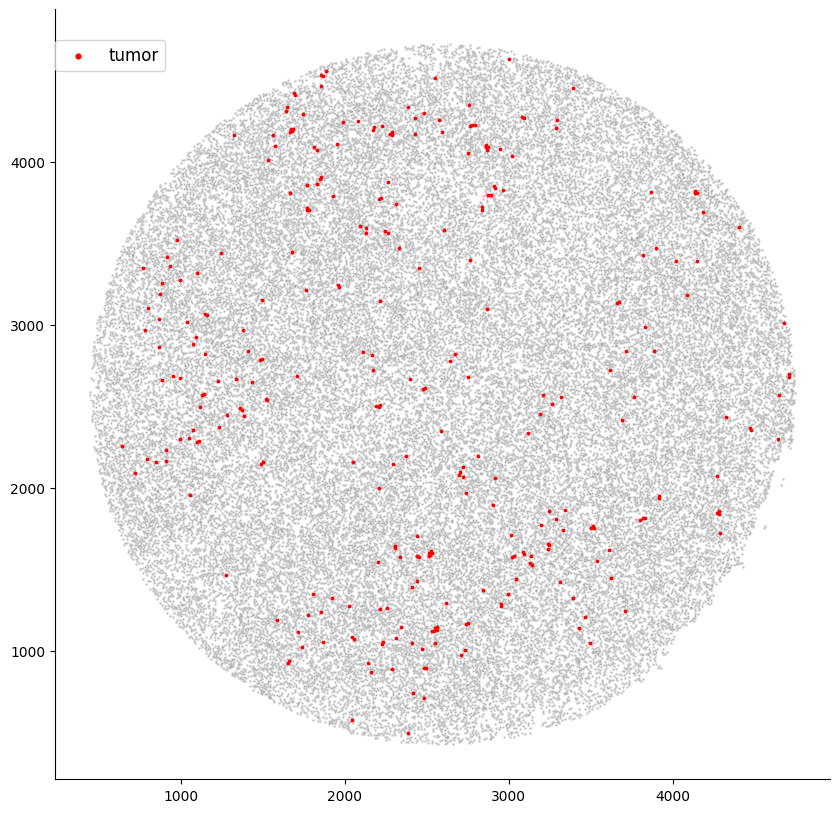

In [45]:
adata_tumor=adata[adata.obs["first_type"]=="Tumor"]

plt.figure(figsize=(10,10))
plt.scatter(adata.obs["x"], adata.obs["y"], s=1,alpha=0.3, color="gray")

plt.scatter(adata_tumor.obs["x"], adata_tumor.obs["y"], s=3,alpha=1, color="red", label="tumor")
plt.legend(bbox_to_anchor=(0.0, 0.96), loc='upper left', borderaxespad=0,markerscale=2, scatterpoints=1, fontsize=12,frameon=True)

plt.show()


In [49]:
def Ripley(adata):
    adata_tumor=adata[adata.obs["first_type"]=="Tumor"]
    if len(adata_tumor.obs)> 100:
        mode = "L"
        ripley_dict=sq.gr.ripley(adata, cluster_key="first_type", mode=mode,max_dist=500, n_simulations=100, copy="True")
        df_puck=ripley_dict["L_stat"]
        df_puck=df_puck[df_puck["bins"] < 200]
        df_tumor=df_puck[df_puck["first_type"]=="Tumor"]
        tumor_stats=df_tumor["stats"].tolist()
        df_sims=ripley_dict["sims_stat"]
        df_sims=df_sims[df_sims["bins"] < 200]
        bin_numbers=np.unique(df_sims["bins"]).tolist()
            
        confidence_lower=[]
        confidence_upper=[]
        tumor_to_sim=[]
        for j in range(len(bin_numbers)):
            confidence_lower.append(np.percentile(df_sims[df_sims["bins"]==bin_numbers[j]]["stats"], 2.5, axis=0))
            confidence_upper.append(np.percentile(df_sims[df_sims["bins"]==bin_numbers[j]]["stats"], 97.5, axis=0))
                
        plt.figure(figsize=(10,10))
        plt.plot(bin_numbers, confidence_lower, alpha=1, color="green", linestyle='--', label="lower_confidence_envelope")
        plt.plot(bin_numbers, tumor_stats, alpha=1, color="blue", label="tumor cells")
        plt.plot(bin_numbers, confidence_upper, alpha=1, color="purple", linestyle='--', label="upper_confidence_envelope")
        plt.fill_between(bin_numbers, confidence_lower, confidence_upper, color="gray", alpha=0.2)
        plt.legend(bbox_to_anchor=(0.02, 0.90), loc='upper left', borderaxespad=0,markerscale=4, scatterpoints=1, fontsize=15,frameon=True)
        plt.xlabel("bins", fontsize=10)
        plt.ylabel("value", fontsize=10)
            
            


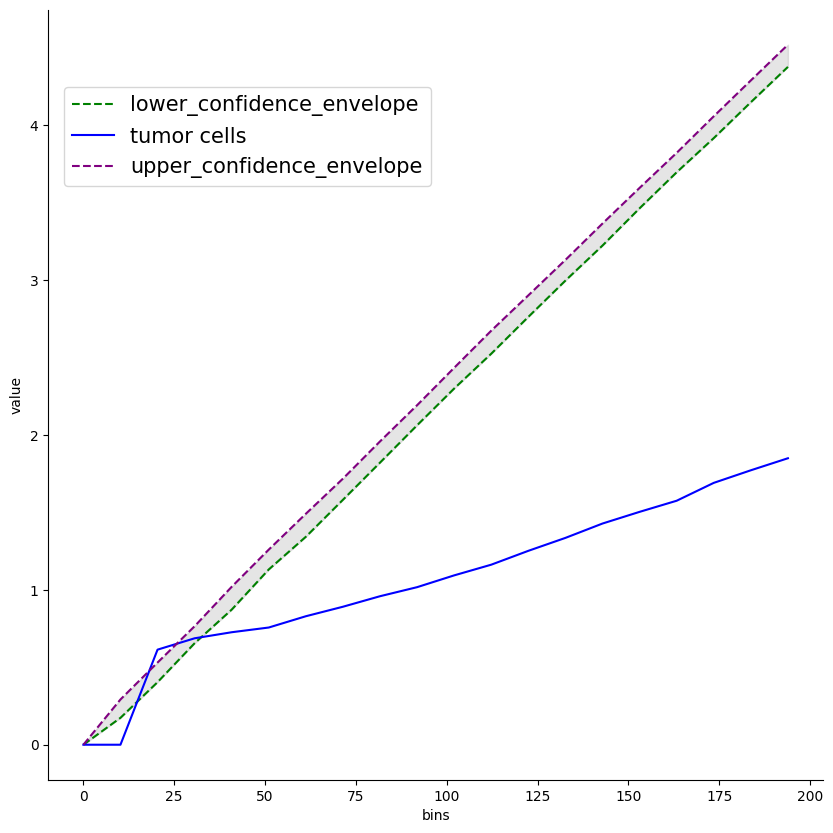

In [50]:
Ripley(adata)

In [52]:
adata=sc.read('/home/ntokcan/Github_2025/Data/SS_1.h5ad')

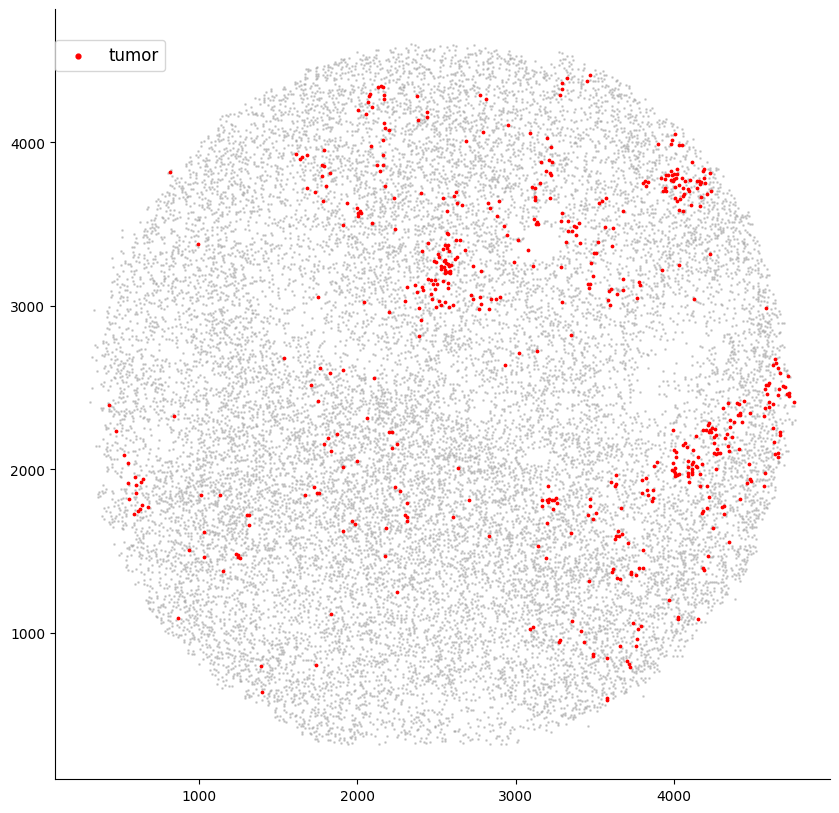

In [53]:
adata_tumor=adata[adata.obs["first_type"]=="Tumor"]

plt.figure(figsize=(10,10))
plt.scatter(adata.obs["x"], adata.obs["y"], s=1,alpha=0.3, color="gray")

plt.scatter(adata_tumor.obs["x"], adata_tumor.obs["y"], s=3,alpha=1, color="red", label="tumor")
plt.legend(bbox_to_anchor=(0.0, 0.96), loc='upper left', borderaxespad=0,markerscale=2, scatterpoints=1, fontsize=12,frameon=True)

plt.show()


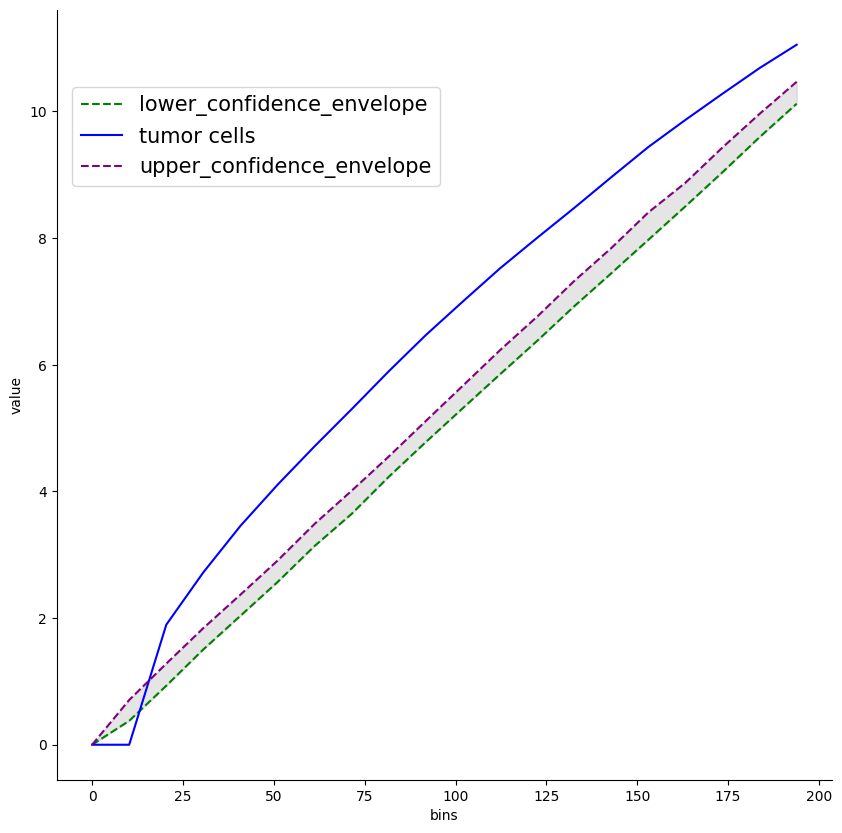

In [54]:
Ripley(adata)